In [4]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, GRU, Activation, LSTM, Bidirectional, MultiHeadAttention, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers.schedules import CosineDecay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import re
#from gensim.models import Word2Vec
import plotly.express as px
import keras.backend as K
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from scipy.stats import entropy


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yassineseidou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yassineseidou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yassineseidou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Lire le fichier texte et ajouter toutes les lignes dans une liste
with open("fleurs_mal.txt", 'r' , encoding = 'utf8') as f:
    lines = f.readlines()

df = ''.join(lines)

tokens = word_tokenize(df.lower())
print("There are :",len(tokens), "words in the document")
print("There are :",len(set(tokens)), "unique words in the document")

There are : 32562 words in the document
There are : 6975 unique words in the document


## Analyse Exploratoire

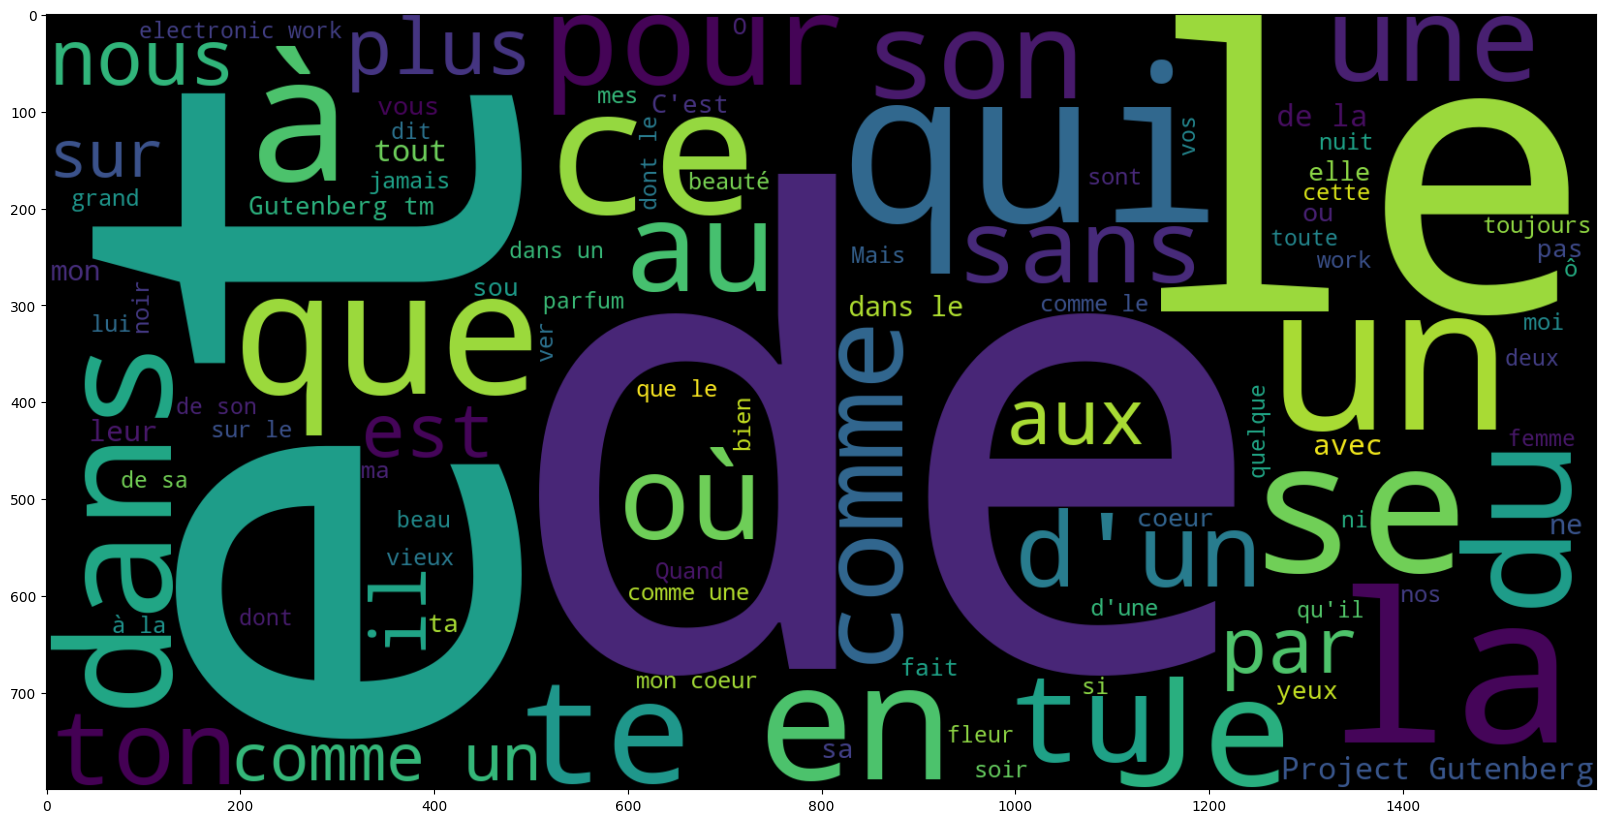

In [6]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=100,
               height=800,
               width=1600,
               ).generate(df)
plt.imshow(wc, interpolation="bilinear")

# visualize the distribution of number of words in a text

fig = px.histogram(x = [len(x) for x in tokens], nbins = 100)
fig.show()

In [7]:
stop_words = stopwords.words('french')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'le', 'la', 'du', 'des', 'un', 'une', 'a'])
stop_words

['au',
 'aux',
 'avec',
 'ce',
 'ces',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'et',
 'eux',
 'il',
 'ils',
 'je',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'ma',
 'mais',
 'me',
 'même',
 'mes',
 'moi',
 'mon',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'ses',
 'son',
 'sur',
 'ta',
 'te',
 'tes',
 'toi',
 'ton',
 'tu',
 'un',
 'une',
 'vos',
 'votre',
 'vous',
 'c',
 'd',
 'j',
 'l',
 'à',
 'm',
 'n',
 's',
 't',
 'y',
 'été',
 'étée',
 'étées',
 'étés',
 'étant',
 'étante',
 'étants',
 'étantes',
 'suis',
 'es',
 'est',
 'sommes',
 'êtes',
 'sont',
 'serai',
 'seras',
 'sera',
 'serons',
 'serez',
 'seront',
 'serais',
 'serait',
 'serions',
 'seriez',
 'seraient',
 'étais',
 'était',
 'étions',
 'étiez',
 'étaient',
 'fus',
 'fut',
 'fûmes',
 'fûtes',
 'furent',
 'sois',
 'soit',
 'soyons',
 'soyez',
 'soient',
 'fusse',
 'fusses',
 'fût',
 'fussions',
 'fussiez',
 'fussent',
 'ayant',
 'ayante',
 'ayantes',


In [8]:
len(stop_words)

157

## Traitement du texte

In [9]:
# Initialisation du lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, stop_words):
    """
    Nettoie et prétraite le texte :
    - Met en minuscule
    - Supprime les caractères spéciaux
    - Tokenize
    - Retire les stopwords
    - Lematise les mots restants
    """
    # Convertir en minuscule
    text = text.lower()
    
    # Supprimer les caractères spéciaux (on garde les mots uniquement)
    text = re.sub(r"[^\w\s]", "", text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Retirer les stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

In [10]:
# Appliquer la fonction au corpus
preprocessed_tokens = preprocess_text(df, stop_words)

In [11]:
# Vérifier les résultats
print("Exemple de tokens prétraités :", preprocessed_tokens[:50])
print("Nombre total de mots après prétraitement :", len(preprocessed_tokens))
print("Nombre de mots uniques après prétraitement :", len(set(preprocessed_tokens)))

Exemple de tokens prétraités : ['the', 'project', 'gutenberg', 'ebook', 'of', 'fleurs', 'mal', 'by', 'charles', 'baudelaire', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restriction', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 'reuse', 'it', 'under', 'the', 'term', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook']
Nombre total de mots après prétraitement : 18235
Nombre de mots uniques après prétraitement : 6654


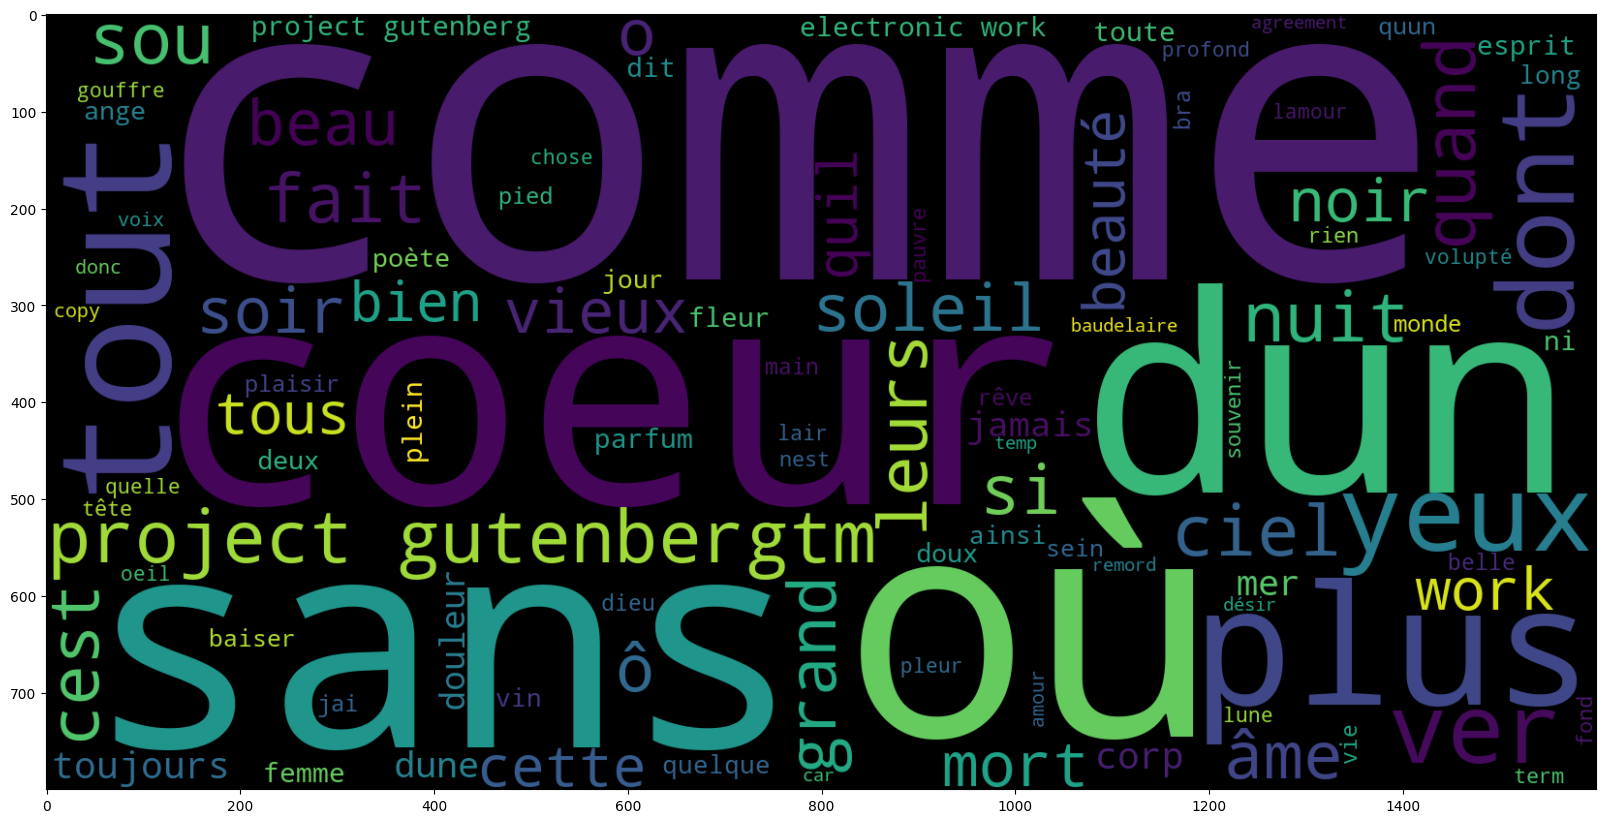

In [12]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=100,
               height=800,
               width=1600,
               ).generate(" ".join(preprocessed_tokens))
plt.imshow(wc, interpolation="bilinear")

# Distribution de la longueur des textes après prétraitement
fig = px.histogram(x=[len(x) for x in preprocessed_tokens], nbins=100)
fig.show()

In [13]:
for idx, line in enumerate(preprocessed_tokens):
    if "Charles Baudelaire" in line:
        first_line = idx
    if "End of the Project" in line:
        last_line = idx

In [14]:
first_line = None
last_line = None
lines = lines[first_line:last_line]
lines = [l.lower().strip().replace('_', '') for l in lines if len(l) > 1]
text = " ".join(lines)

In [15]:
characters = sorted(set(text))
n_characters = len(characters)

In [16]:
# SEQLEN représente la taille de la séquence de lettres à passer en entrée
SEQLEN = 10
step = 1
input_characters, labels = [], []
# On parcourt le corpus de texte avec une fenêtre glissante
for i in range(0, len(text) - SEQLEN, step):
    input_characters.append(text[i:i + SEQLEN])
    labels.append(text[i + SEQLEN])

print(f"Il y a {len(input_characters)} séquences de {SEQLEN} caractères dans le corpus d'entraînement.")

Il y a 165482 séquences de 10 caractères dans le corpus d'entraînement.


In [17]:
# Encodage caractère -> indice du dictionaire
char2index = dict((c, i) for i, c in enumerate(characters))
# Encodage de l'indice vers le caractère (utilisé pour décoder les prédictions du modèle)
index2char = dict((i, c) for i, c in enumerate(characters)) # mapping index -> char in dictionary

In [18]:
# Initialisation des tenseurs
X = np.zeros((len(input_characters), SEQLEN, n_characters), dtype=bool)
y = np.zeros((len(input_characters), n_characters), dtype=bool)

# Remplissage des tenseurs X et y
for idx_seq, sequence in enumerate(input_characters):
    for idx_char, char in enumerate(sequence):
        # Encode chaque caractère dans une représentation one-hot
        X[idx_seq, idx_char, char2index[char]] = 1
    # Encode le caractère cible correspondant
    y[idx_seq, char2index[labels[idx_seq]]] = 1

print("Encodage terminé.")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Encodage terminé.
X shape: (165482, 10, 72), y shape: (165482, 72)


In [19]:
from sklearn.model_selection import train_test_split

# 80% des données en apprentissage, 20% en validation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

### Model

In [28]:
from tensorflow.keras.callbacks import Callback

# Cosine Annealing Scheduler
class CosineAnnealingScheduler(Callback):
    def __init__(self, max_lr, min_lr, total_epochs):
        super(CosineAnnealingScheduler, self).__init__()
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        # Calculer le learning rate pour l'epoch courant
        cosine_lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (
            1 + np.cos(np.pi * epoch / self.total_epochs)
        )
        # Mettre à jour le learning rate de l'optimiseur
        self.model.optimizer.lr.assign(cosine_lr)
        print(f"Epoch {epoch+1}: Learning rate is {cosine_lr:.6f}")

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2

weight_decay = 0.0001  # L2 regularization value

class minGRU(Layer):
    def __init__(self, units, return_sequences=False, kernel_regularizer=None, **kwargs):
        super(minGRU, self).__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
        
    def build(self, input_shape):
        input_dim = input_shape[-1]
        
        # Initialize the weight matrices with regularization
        self.W_z = self.add_weight(
            shape=(input_dim, self.units),
            initializer='glorot_uniform',
            regularizer=self.kernel_regularizer,
            name='W_z'
        )
        self.U_z = self.add_weight(
            shape=(self.units, self.units),
            initializer='glorot_uniform',
            regularizer=self.kernel_regularizer,
            name='U_z'
        )
        self.b_z = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            name='b_z'
        )
        
        self.W_h = self.add_weight(
            shape=(input_dim, self.units),
            initializer='glorot_uniform',
            regularizer=self.kernel_regularizer,
            name='W_h'
        )
        self.U_h = self.add_weight(
            shape=(self.units, self.units),
            initializer='glorot_uniform',
            regularizer=self.kernel_regularizer,
            name='U_h'
        )
        self.b_h = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            name='b_h'
        )
        
        self.built = True

    def step(self, x_t, h_prev):
        """Single time step processing"""
        # Update gate
        z_t = tf.sigmoid(
            tf.matmul(x_t, self.W_z) + 
            tf.matmul(h_prev, self.U_z) + 
            self.b_z
        )
        
        # Candidate hidden state
        h_tilde = tf.tanh(
            tf.matmul(x_t, self.W_h) + 
            tf.matmul(h_prev, self.U_h) + 
            self.b_h
        )
        
        # New hidden state
        h_t = (1 - z_t) * h_prev + z_t * h_tilde
        return h_t

    def call(self, inputs):
        # Initialize hidden state
        batch_size = tf.shape(inputs)[0]
        h_prev = tf.zeros([batch_size, self.units])
        
        # Process sequence
        time_steps = tf.shape(inputs)[1]
        outputs = tf.TensorArray(tf.float32, size=time_steps)
        
        for t in range(time_steps):
            x_t = inputs[:, t, :]
            h_prev = self.step(x_t, h_prev)
            outputs = outputs.write(t, h_prev)
        
        final_outputs = tf.transpose(outputs.stack(), perm=[1, 0, 2])
        
        if self.return_sequences:
            return final_outputs
        return h_prev

def create_model(input_shape, output_features):
    model = tf.keras.Sequential([
        minGRU(128, return_sequences=True, 
               kernel_regularizer=l2(weight_decay),
               input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        
        minGRU(128, return_sequences=True,
               kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.2),
        minGRU(128, return_sequences=True,
               kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.2),
        minGRU(128, return_sequences=True,
               kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.2),
        
        minGRU(128, return_sequences=False,
               kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(output_features),
        Activation("softmax")
    ])
    return model

# Update model configuration to match data dimensions
input_shape = (10, 72)  # Match X_train shape
output_features = 72    # Match y_train shape

model = create_model(input_shape, output_features)

# Optimizer setup
initial_learning_rate = 0.001
batch_size = 128
num_epochs = 100
decay_steps = num_epochs * (116896 // batch_size)
cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps
)
optim = Adam(initial_learning_rate)

model.compile(
    loss="categorical_crossentropy",
    optimizer=optim,
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 min_gru_10 (minGRU)         (None, None, 128)         51456     
                                                                 
 batch_normalization_10 (Ba  (None, None, 128)         512       
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, None, 128)         0         
                                                                 
 min_gru_11 (minGRU)         (None, None, 128)         65792     
                                                                 
 batch_normalization_11 (Ba  (None, None, 128)         512       
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, None, 128)        

Epoch 1: Learning rate is 0.001000
Epoch 1/100
1035/1035 [==============================] - 72s 67ms/step - loss: 3.3379 - accuracy: 0.1868 - val_loss: 2.6951 - val_accuracy: 0.2802
Epoch 2: Learning rate is 0.001000
Epoch 2/100
1035/1035 [==============================] - 70s 67ms/step - loss: 2.5312 - accuracy: 0.3192 - val_loss: 2.2630 - val_accuracy: 0.3778
Epoch 3: Learning rate is 0.000999
Epoch 3/100
1035/1035 [==============================] - 69s 67ms/step - loss: 2.2823 - accuracy: 0.3712 - val_loss: 2.1004 - val_accuracy: 0.4151
Epoch 4: Learning rate is 0.000998
Epoch 4/100
1035/1035 [==============================] - 69s 67ms/step - loss: 2.1658 - accuracy: 0.3984 - val_loss: 2.0178 - val_accuracy: 0.4352
Epoch 5: Learning rate is 0.000996
Epoch 5/100
1035/1035 [==============================] - 69s 66ms/step - loss: 2.0911 - accuracy: 0.4164 - val_loss: 1.9666 - val_accuracy: 0.4470
Epoch 6: Learning rate is 0.000994
Epoch 6/100
1035/1035 [==============================] 

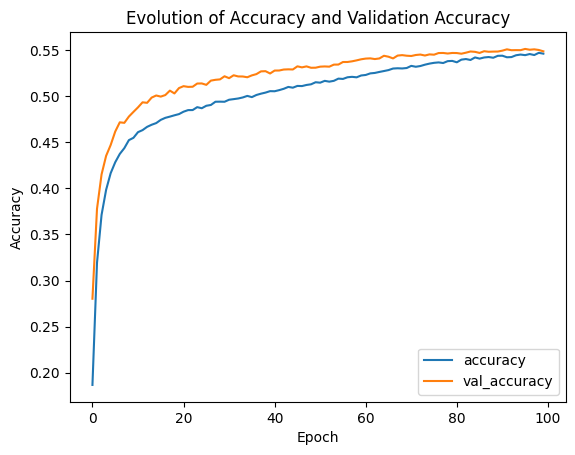

In [30]:


#model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs)
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy

cosine_scheduler = CosineAnnealingScheduler(max_lr=0.001, min_lr=0.0001, total_epochs=num_epochs)
# Définition de l'EarlyStopping pour arrêter l'entraînement en cas de surapprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Visualisation de l'évolution de l'accuracy et de la val_accuracy
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[cosine_scheduler])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Evolution of Accuracy and Validation Accuracy')
plt.show()

Layer: min_gru_10
W_z shape: (72, 128)


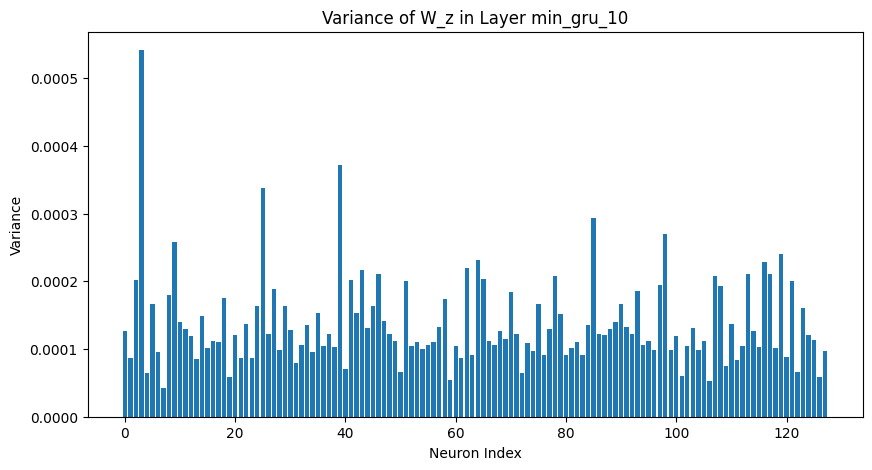

U_z shape: (128, 128)


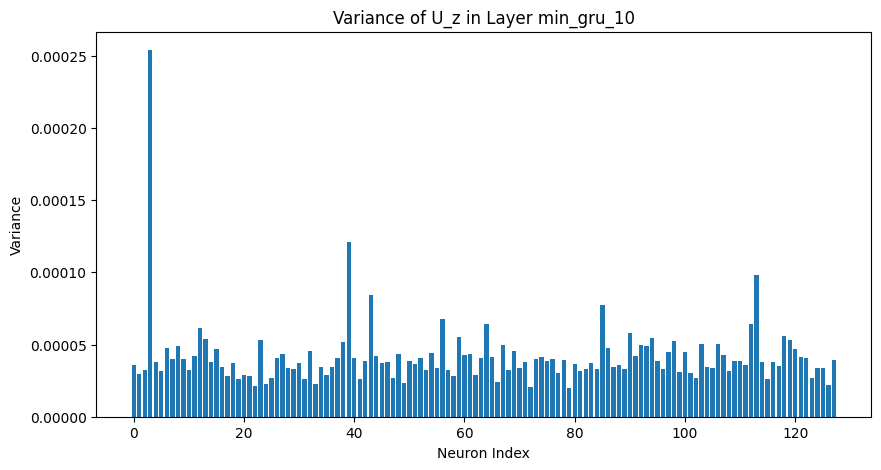

b_z shape: (128,)


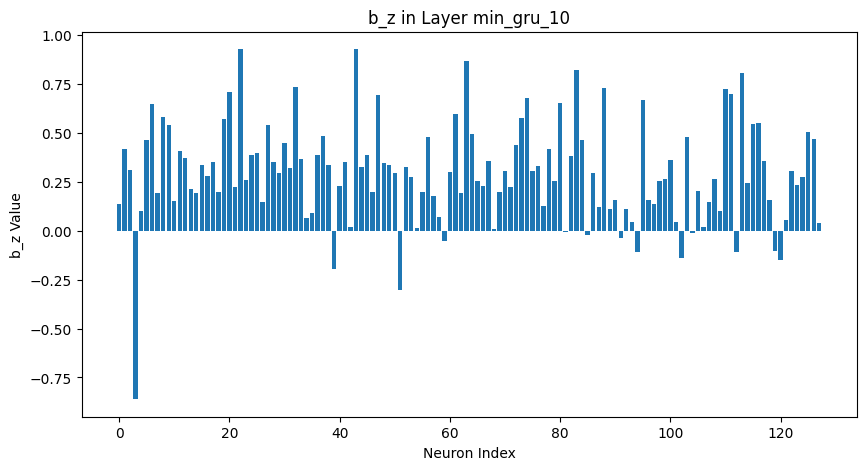

W_h shape: (72, 128)


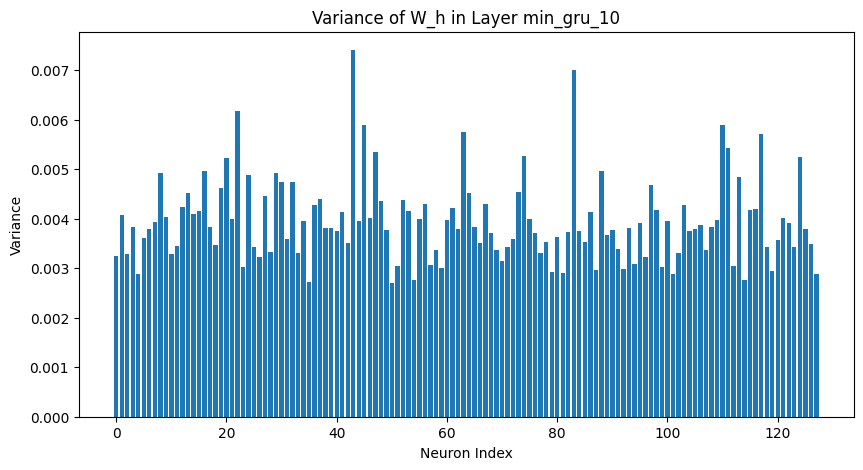

U_h shape: (128, 128)


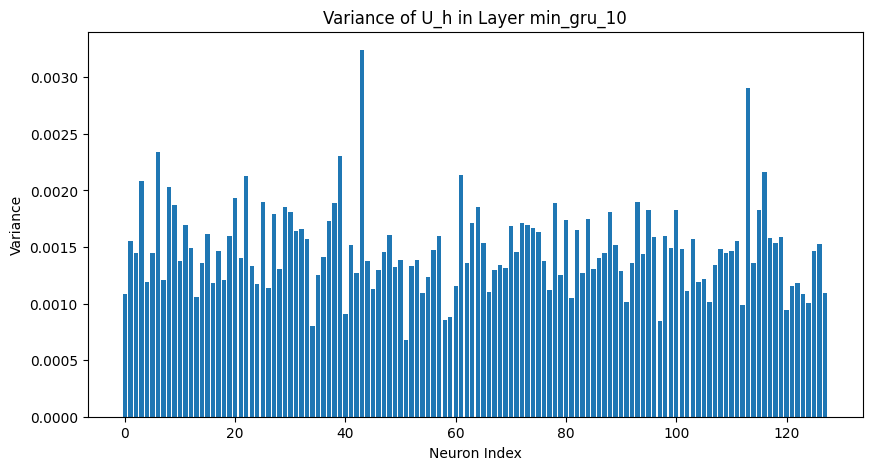

b_h shape: (128,)


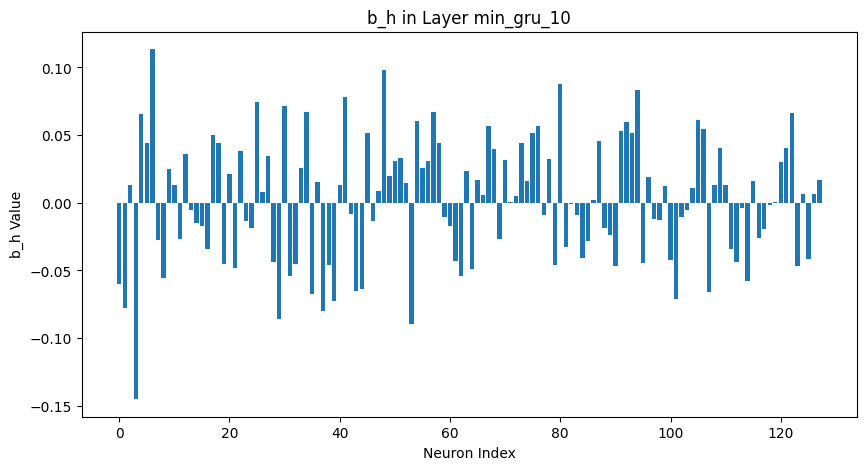

Layer batch_normalization_10 is not a SimpleRNN, GRU, Dense, or minGRU layer.
Layer dropout_10 is not a SimpleRNN, GRU, Dense, or minGRU layer.
Layer: min_gru_11
W_z shape: (128, 128)


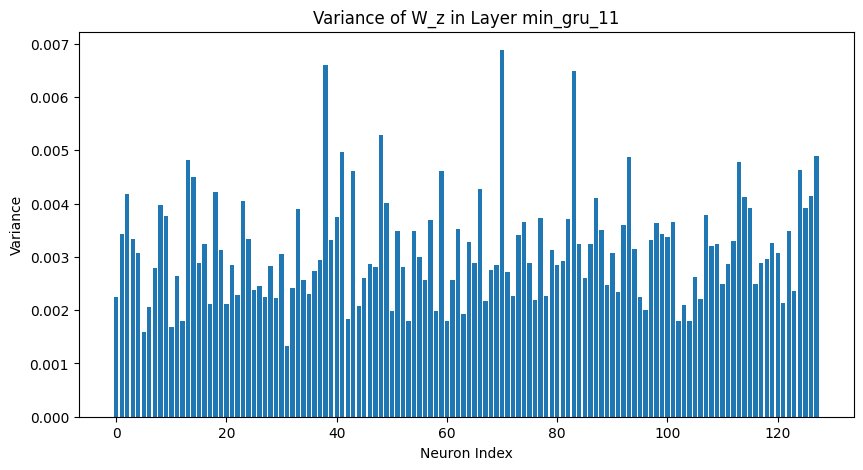

U_z shape: (128, 128)


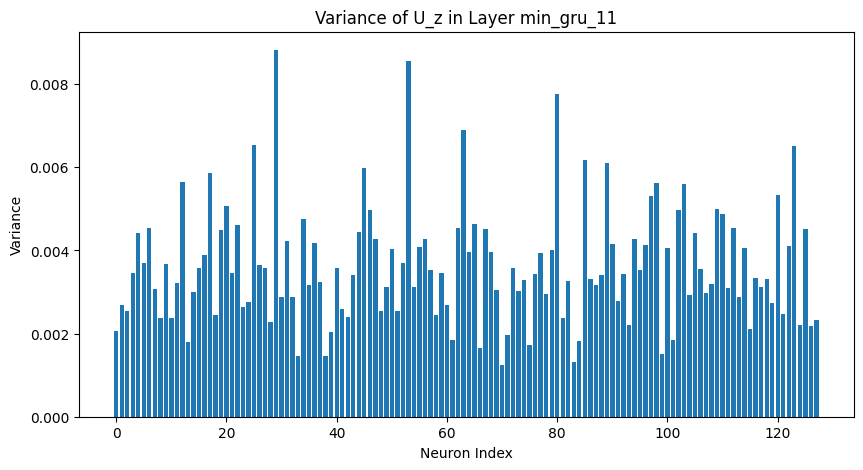

b_z shape: (128,)


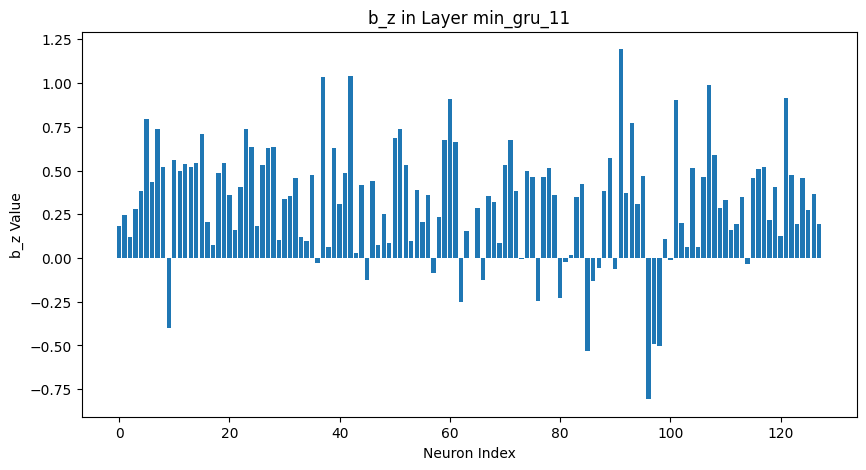

W_h shape: (128, 128)


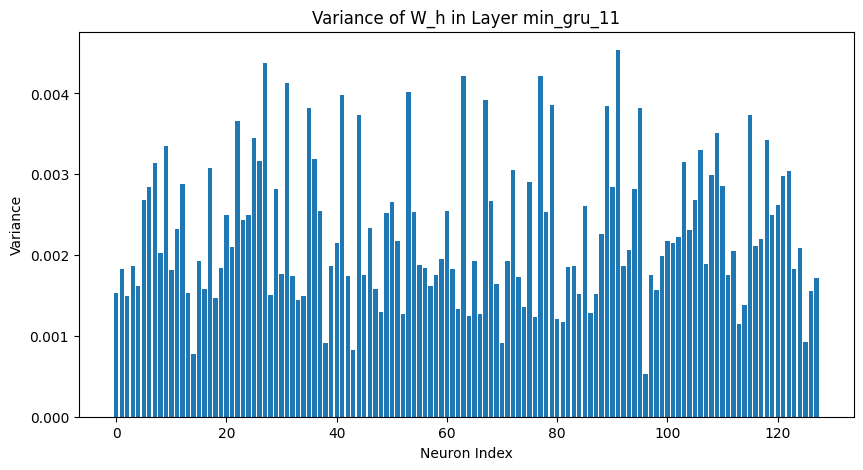

U_h shape: (128, 128)


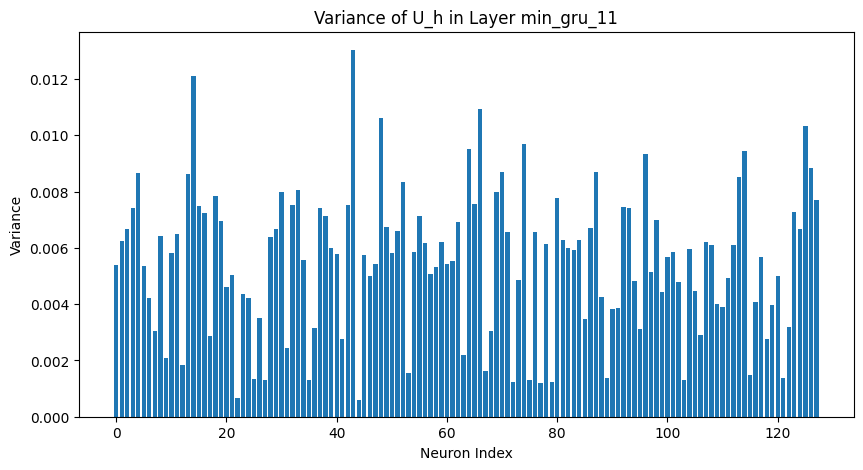

b_h shape: (128,)


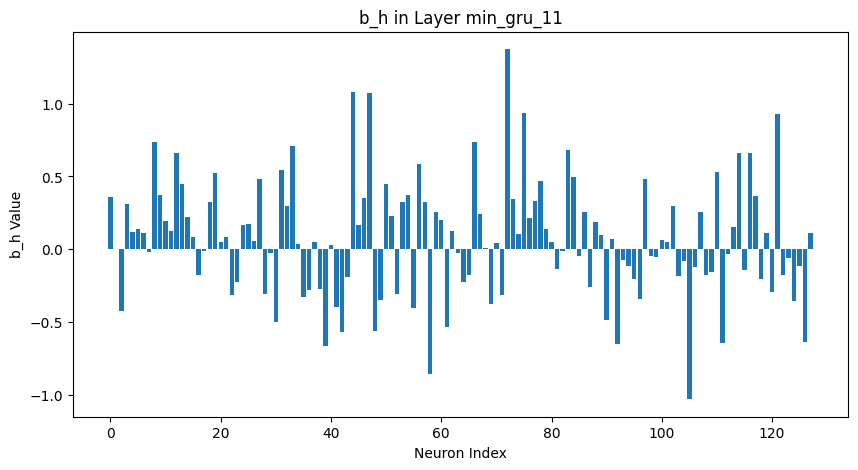

Layer batch_normalization_11 is not a SimpleRNN, GRU, Dense, or minGRU layer.
Layer dropout_11 is not a SimpleRNN, GRU, Dense, or minGRU layer.
Layer: min_gru_12
W_z shape: (128, 128)


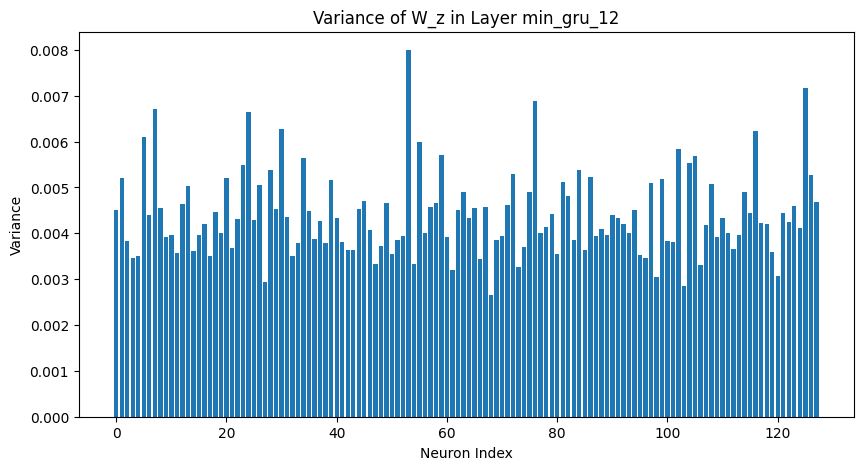

U_z shape: (128, 128)


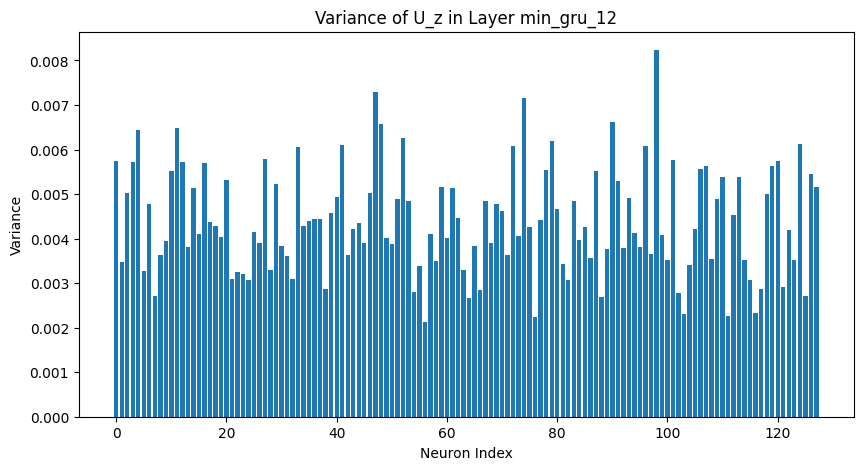

b_z shape: (128,)


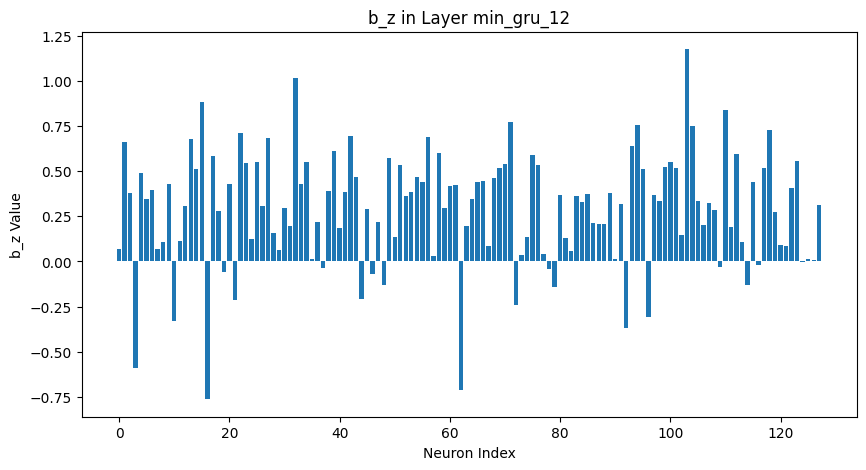

W_h shape: (128, 128)


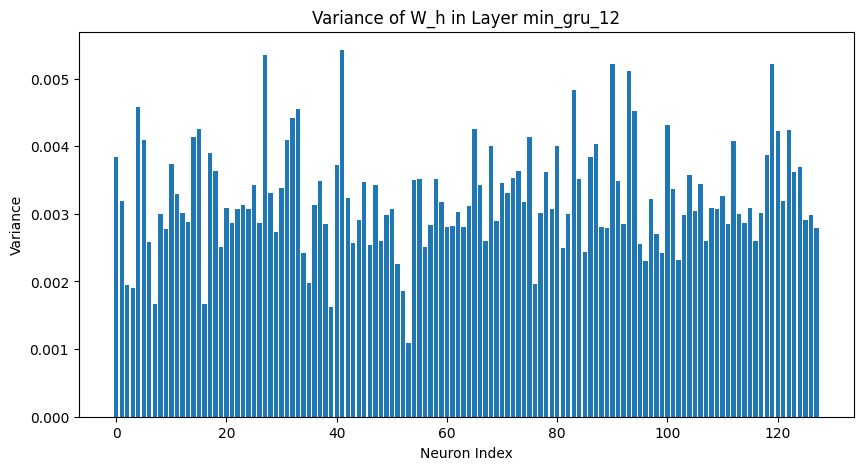

U_h shape: (128, 128)


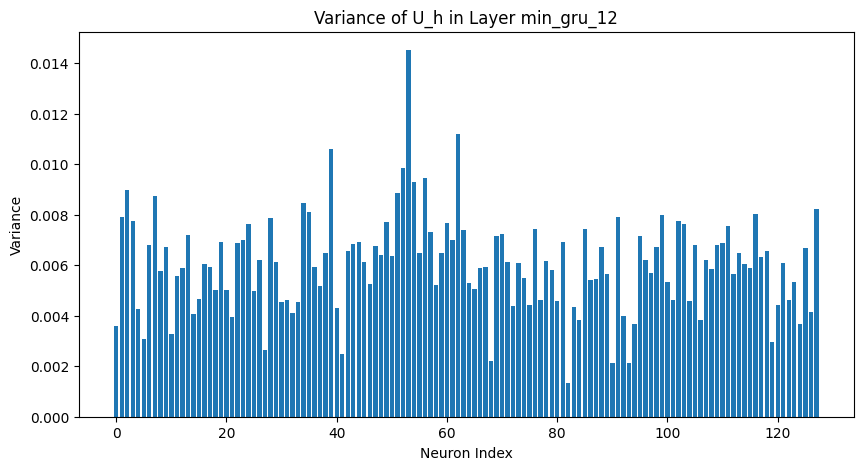

b_h shape: (128,)


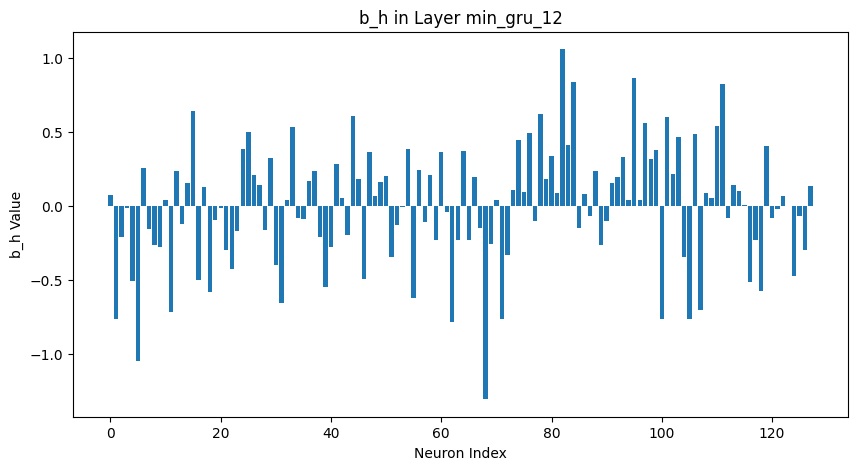

Layer batch_normalization_12 is not a SimpleRNN, GRU, Dense, or minGRU layer.
Layer dropout_12 is not a SimpleRNN, GRU, Dense, or minGRU layer.
Layer: min_gru_13
W_z shape: (128, 128)


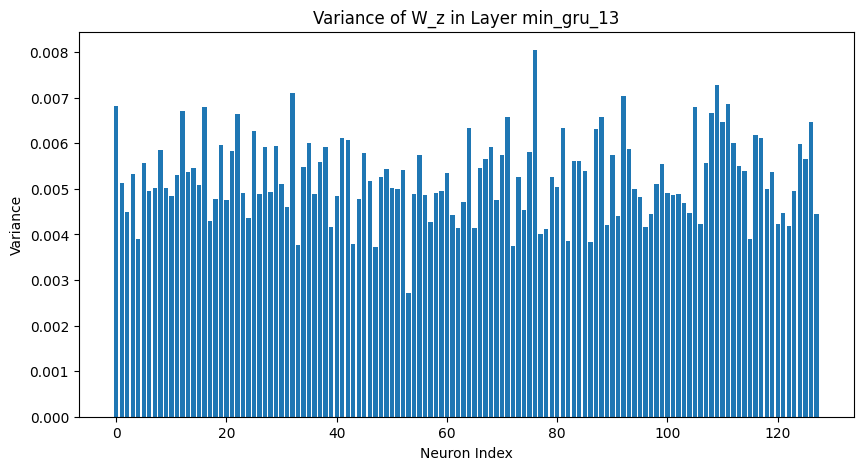

U_z shape: (128, 128)


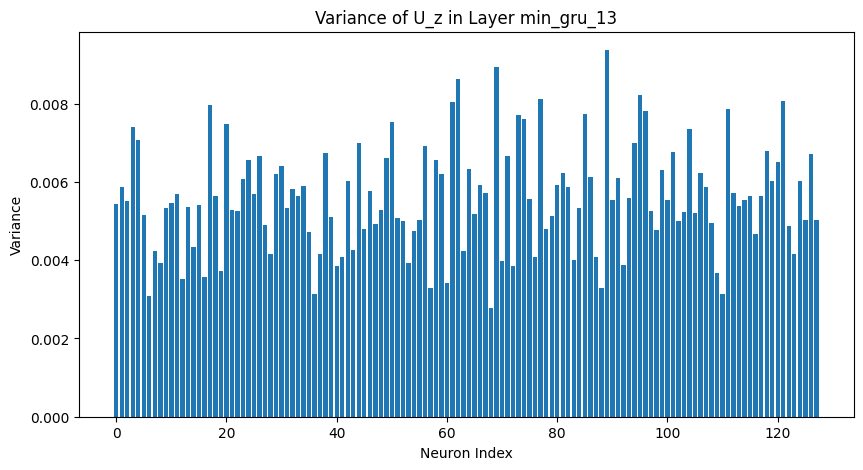

b_z shape: (128,)


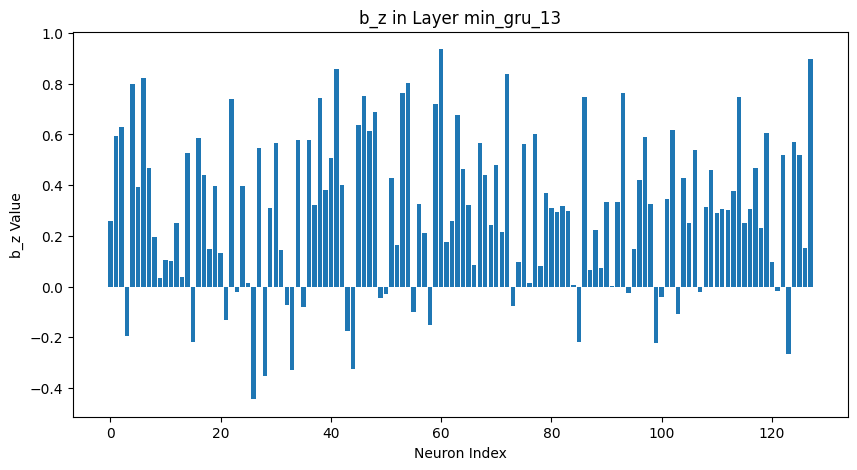

W_h shape: (128, 128)


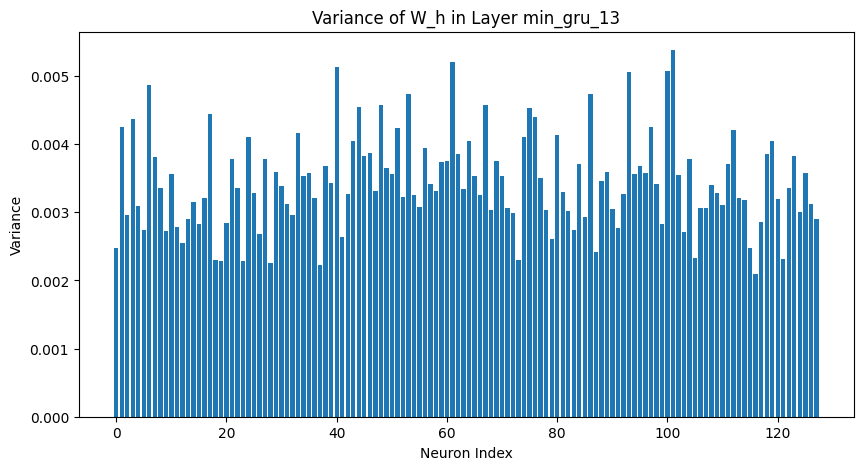

U_h shape: (128, 128)


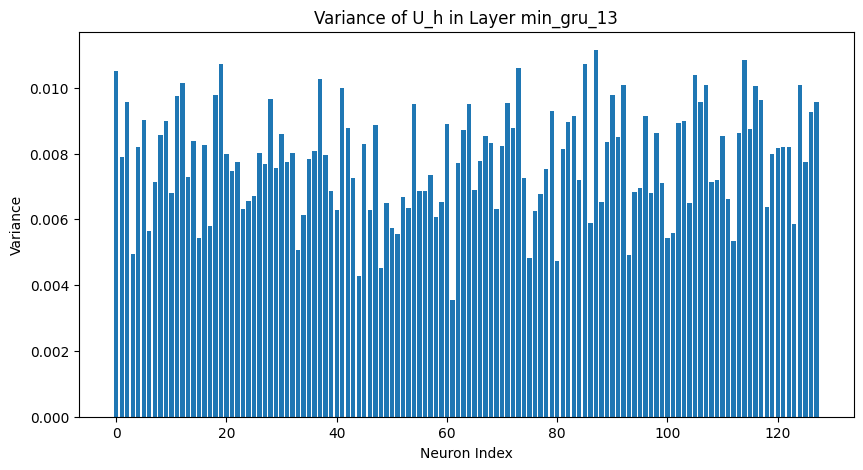

b_h shape: (128,)


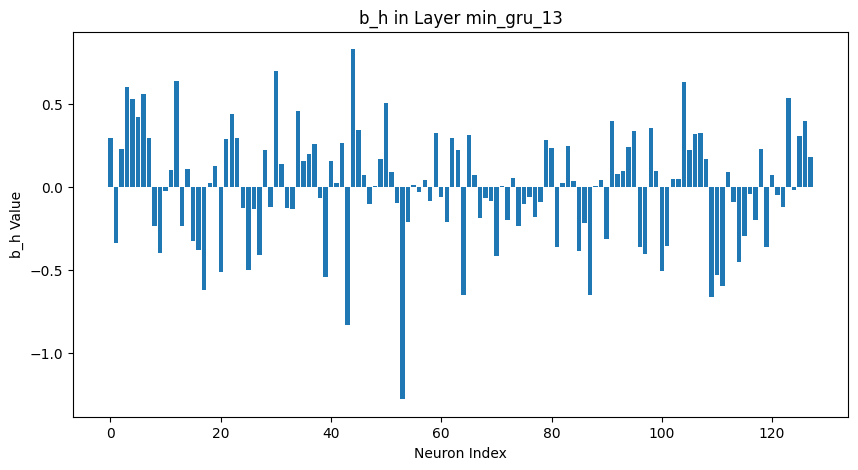

Layer batch_normalization_13 is not a SimpleRNN, GRU, Dense, or minGRU layer.
Layer dropout_13 is not a SimpleRNN, GRU, Dense, or minGRU layer.
Layer: min_gru_14
W_z shape: (128, 128)


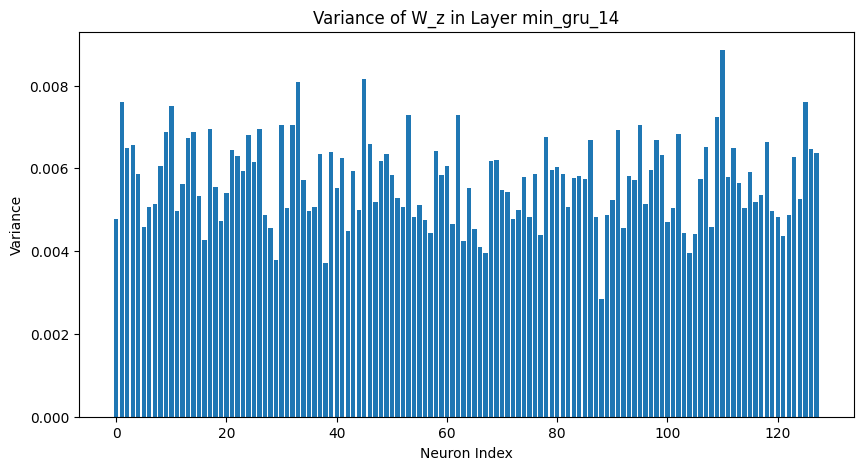

U_z shape: (128, 128)


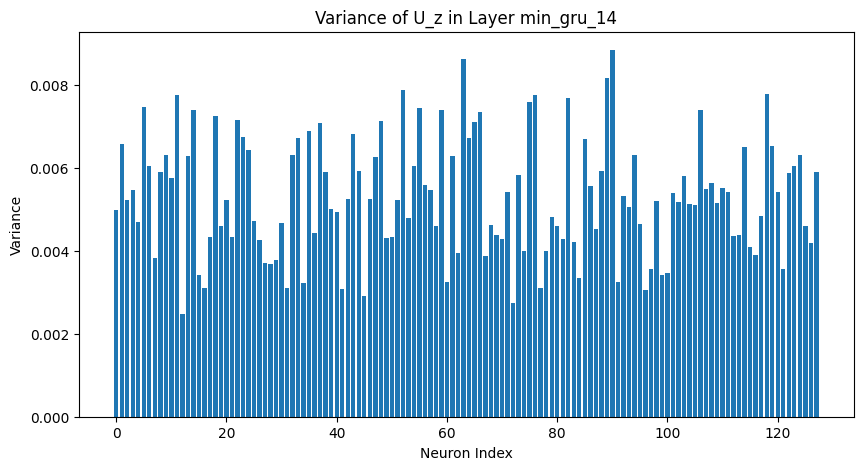

b_z shape: (128,)


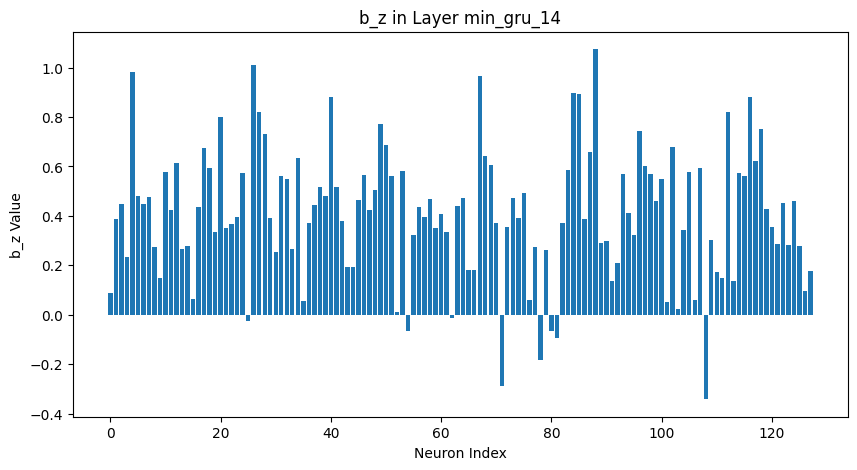

W_h shape: (128, 128)


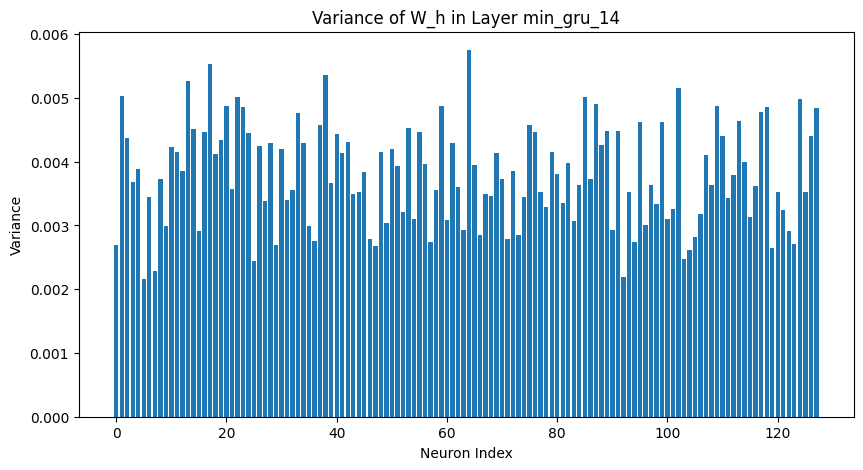

U_h shape: (128, 128)


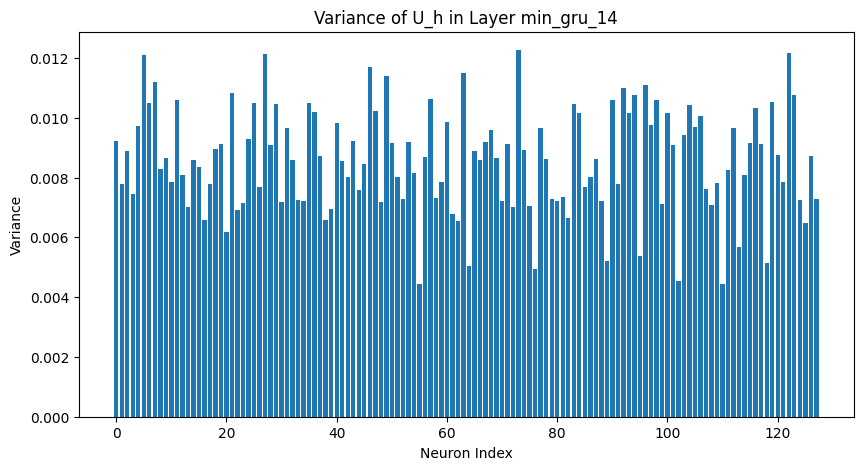

b_h shape: (128,)


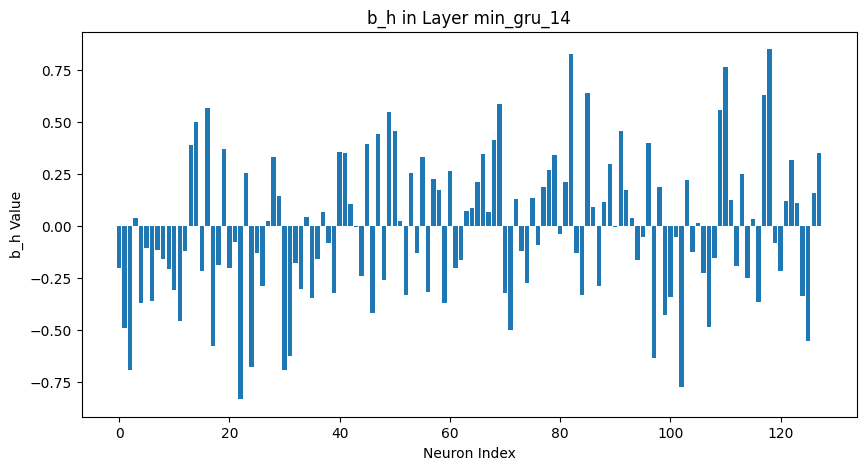

Layer batch_normalization_14 is not a SimpleRNN, GRU, Dense, or minGRU layer.
Layer dropout_14 is not a SimpleRNN, GRU, Dense, or minGRU layer.
Layer: dense_2
Weights shape: (128, 72), Biases shape: (72,)


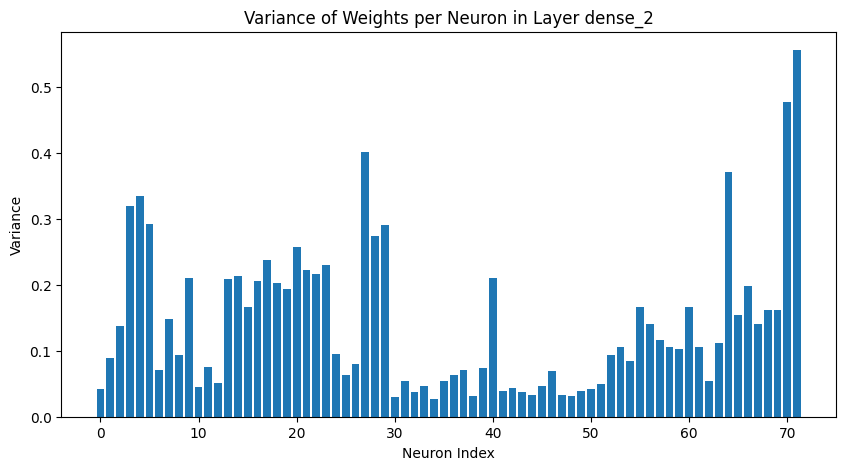

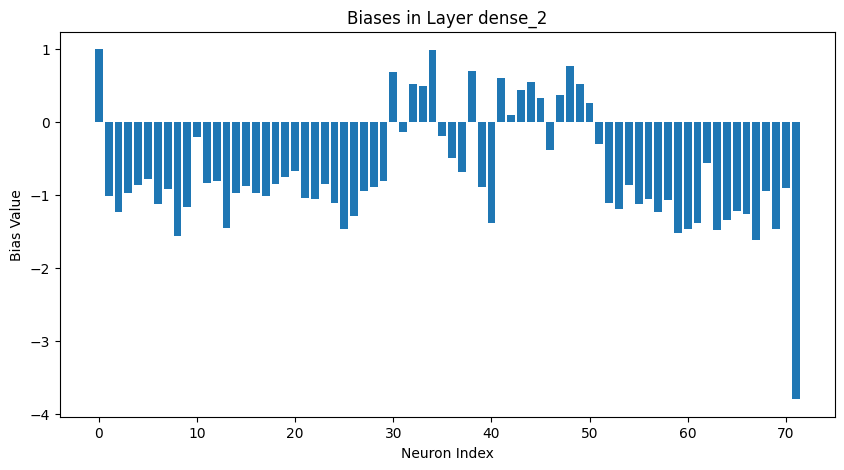

Layer activation_2 is not a SimpleRNN, GRU, Dense, or minGRU layer.


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, GRU, Dense

def plot_layer_parameters(model):
    for layer in model.layers:
        if isinstance(layer, (SimpleRNN, GRU, Dense)):
            # Handle SimpleRNN, GRU, Dense layers as before
            layer_weights = layer.get_weights()
            
            if len(layer_weights) >= 2:
                weights = layer_weights[0]
                biases = layer_weights[1]
                
                print(f"Layer: {layer.name}")
                print(f"Weights shape: {weights.shape}, Biases shape: {biases.shape}")
                
                weight_variances = np.var(weights, axis=0)
                
                # Plot the variance of weights
                plt.figure(figsize=(10, 5))
                plt.bar(range(len(weight_variances)), weight_variances)
                plt.title(f'Variance of Weights per Neuron in Layer {layer.name}')
                plt.xlabel('Neuron Index')
                plt.ylabel('Variance')
                plt.show()
                
                if len(biases.shape) == 1:
                    plt.figure(figsize=(10, 5))
                    plt.bar(range(len(biases)), biases)
                    plt.title(f'Biases in Layer {layer.name}')
                    plt.xlabel('Neuron Index')
                    plt.ylabel('Bias Value')
                    plt.show()
                else:
                    print(f"Biases in layer {layer.name} have a complex shape and cannot be plotted directly.")
            else:
                print(f"Layer {layer.name} does not have standard weights and biases.")
        
        elif isinstance(layer, minGRU):
            # Handle minGRU layer
            layer_weights = [
                layer.W_z.numpy(), layer.U_z.numpy(), layer.b_z.numpy(),
                layer.W_h.numpy(), layer.U_h.numpy(), layer.b_h.numpy()
            ]
            
            print(f"Layer: {layer.name}")
            for i, param in enumerate(layer_weights):
                param_name = ['W_z', 'U_z', 'b_z', 'W_h', 'U_h', 'b_h'][i]
                print(f"{param_name} shape: {param.shape}")
                
                # Only compute variance if the parameter has more than one dimension
                if len(param.shape) > 1:
                    weight_variances = np.var(param, axis=0)
                    plt.figure(figsize=(10, 5))
                    plt.bar(range(len(weight_variances)), weight_variances)
                    plt.title(f'Variance of {param_name} in Layer {layer.name}')
                    plt.xlabel('Neuron Index')
                    plt.ylabel('Variance')
                    plt.show()
                else:
                    # If the parameter is 1D, just plot the values
                    plt.figure(figsize=(10, 5))
                    plt.bar(range(len(param)), param)
                    plt.title(f'{param_name} in Layer {layer.name}')
                    plt.xlabel('Neuron Index')
                    plt.ylabel(f'{param_name} Value')
                    plt.show()
        
        else:
            print(f"Layer {layer.name} is not a SimpleRNN, GRU, Dense, or minGRU layer.")

# Call the function with your model
plot_layer_parameters(model)


In [32]:
scores_train = model.evaluate(X_train, y_train, verbose=1)
scores_test = model.evaluate(X_test, y_test, verbose=1)
print(f"Performances (apprentissage, {model.metrics_names[1]}) = {scores_train[1]*100:.2f}")
print(f"Performances (validation, {model.metrics_names[1]}) = {scores_test[1]*100:.2f}")


1035/1035 [==============================] - 5s 5ms/step - loss: 1.6081 - accuracy: 0.5486
Performances (apprentissage, accuracy) = 60.80
Performances (validation, accuracy) = 54.86


In [ ]:
#model_name = f"SimpleRNN_{h_size}_{num_epochs}epochs"
#model.save(model_name)

In [ ]:
#from tensorflow.keras.models import load_model
#model = load_model(model_name)
#model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
#model.summary()

In [33]:
idx = 10
# index2char permet de repasser de l'encodage one-hot au caractère du dictionnaire
initial_characters = [index2char[np.argmax(c)] for c in X_train[idx]]
initial_text = "".join(initial_characters)
print(f"La séquence n°{idx} est : '{initial_text}'")

La séquence n°10 est : ', bien qu''


In [34]:
test_sequence = np.zeros((1, SEQLEN, n_characters), dtype=bool)
test_sequence[0] = X_train[idx]
prediction = model.predict(test_sequence)
print(prediction)

1/1 [==============================] - 0s 312ms/step
[[1.21805641e-07 8.01588769e-08 3.46206092e-10 4.81486240e-10
  1.91996485e-09 8.96677038e-11 3.16047249e-03 7.50303215e-08
  6.04389015e-07 2.18736162e-07 3.36034333e-07 1.60574518e-06
  1.31800607e-06 2.95850081e-11 1.70620573e-10 7.56484031e-09
  1.33648195e-08 1.84027327e-09 1.65830139e-09 9.38402493e-08
  4.57959235e-12 3.94938260e-09 1.99236849e-10 7.04697689e-11
  3.23904015e-09 1.67581895e-08 1.78656627e-08 1.46559240e-11
  1.15892484e-09 2.24102889e-10 1.52219906e-01 5.02766816e-05
  1.75838519e-04 1.32406922e-03 1.61152512e-01 1.12736343e-04
  3.28177998e-06 9.21623223e-03 2.54313082e-01 9.65978659e-04
  2.76496559e-09 3.10569606e-03 2.27090510e-04 5.21646347e-04
  5.91917336e-02 3.16636753e-04 2.15867476e-05 6.43781619e-03
  4.41378725e-05 4.42999124e-04 2.93919027e-01 1.67078993e-04
  2.88858482e-05 1.43564625e-06 3.30831273e-04 8.99932999e-08
  7.04890845e-05 6.35117203e-08 3.02245133e-02 3.54101503e-04
  4.47271560e-07 

In [35]:
def sample(probabilities, temperature=1.0):
    probabilities = np.asarray(probabilities).astype('float64')
    # Modifie la distribution selon la valeur de la température
    probabilities = pow(probabilities, 1.0/temperature)
    probabilities /= np.sum(probabilities)
    # Tire des variables aléatoires selon la distribution multinomiale transformée
    random_values = np.random.multinomial(1, probabilities, 1)
    # Renvoie le symbole échantillonné
    return np.argmax(random_values)

In [36]:
# Longueur du texte à générer (en caractères)
text_length = 200
# Température
temperature = 0.5

generated_text = initial_text
network_input = test_sequence

for i in range(text_length):
    last_characters = generated_text[-SEQLEN:]
    
    # Préparer l'entrée pour la prédiction
    test_sequence = np.zeros((1, SEQLEN, n_characters), dtype=bool)
    for t, char in enumerate(last_characters):
        test_sequence[0, t, char2index[char]] = 1
    
    # Prédiction du modèle
    prediction = model.predict(test_sequence, verbose=0)
    
    # Échantillonner un caractère à partir de la distribution de probabilité
    predicted_char_index = sample(prediction[0], temperature)
    predicted_char = index2char[predicted_char_index]
    
    # Ajouter le caractère prédit au texte généré
    generated_text += predicted_char

print("Texte généré:")
print(generated_text)

Texte généré:
, bien qu'il est des leurs repours de la tombe et des démons de l'amour de la parfum, plus en des coups par l'ondre et sans rêves des beaux flambes de vos souvenirs et vaincu, et qui s'étale et jamais le vieux 


In [37]:


# Fonction de softmax
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))  # Stabilité numérique
    return exp_logits / np.sum(exp_logits)

# Fonction de sampling avec température et top-k
def sample(preds, temperature=1.0, top_k=5):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-10) / temperature  # Appliquer température
    preds = softmax(preds)

    # Optionnel: Limiter aux k meilleures probabilités
    if top_k > 0:
        top_k_indices = np.argsort(preds)[-top_k:]
        preds_top_k = preds[top_k_indices]
        preds_top_k /= np.sum(preds_top_k)  # Renormaliser
        return np.random.choice(top_k_indices, p=preds_top_k)
    
    return np.random.choice(len(preds), p=preds)

# 3. Génération de texte avec self-probing et calcul de l'entropie
def generate_text_with_entropy(model, initial_text, text_length=200, temperature=0.7, num_samples=10, top_k=5):
    generated_texts = []
    entropies = []
    
    for _ in range(num_samples):
        generated_text = initial_text
        network_input = np.zeros((1, SEQLEN, n_characters), dtype=bool)
        for t, char in enumerate(initial_text):
            if char in char2index:
                network_input[0, t, char2index[char]] = 1
        
        for i in range(text_length):
            prediction = model.predict(network_input, verbose=0)[0]

            # Appliquer le sampling
            predicted_char_index = sample(prediction, temperature, top_k)
            predicted_char = index2char[predicted_char_index]
            
            # Ajouter le caractère prédit au texte généré
            generated_text += predicted_char
            
            # Mettre à jour l'entrée du réseau (Recréer plutôt que décaler)
            network_input = np.zeros((1, SEQLEN, n_characters), dtype=bool)
            last_chars = generated_text[-SEQLEN:]
            for t, char in enumerate(last_chars):
                if char in char2index:
                    network_input[0, t, char2index[char]] = 1
        
        generated_texts.append(generated_text)
        
        # Calcul de l'entropie sur la dernière sortie
        logits = model.predict(network_input, verbose=0)[0]
        probs = softmax(logits)  # Softmax appliqué correctement
        entropies.append(entropy(probs))
    
    return generated_texts, entropies

# Génération de texte avec self-probing et calcul de l'entropie
generated_texts, entropies = generate_text_with_entropy(model, initial_text, text_length=200, temperature=0.7, num_samples=10, top_k=5)

for i, (text, ent) in enumerate(zip(generated_texts, entropies)):
    print(f"Sample {i+1}:")
    print(text)
    print(f"Entropy: {ent:.4f}")
    print("-" * 80)

Sample 1:
, bien qu'un chant sur la très bouche de la femme ses deux aimes et dont la main de la trouce et de sa langueur, et de la frile, aux flancs qui serveur de mon âme de couleur, les baudelaire, et par sa fait d'un
Entropy: 4.2687
--------------------------------------------------------------------------------
Sample 2:
, bien qu'allonge et la fleur de sa lourde son caresse et son abranche d'autour, mon âme comme une fleur qui fait dans un parfum de tous la mers ses désents par les douceurs des fleurs et parfum, et leurs souve
Entropy: 4.2637
--------------------------------------------------------------------------------
Sample 3:
, bien qu'en sur ses brouts, et dont les marmines! les flammes de vos coucher avait le fouet du plus d'un rêve sans morceaux, et dans l'ardiste, comme une fois, sur les charmes dans l'heure où l'or d'une poète 
Entropy: 4.2757
--------------------------------------------------------------------------------
Sample 4:
, bien qu'il est qui d'une façant la

In [38]:
entropies

[4.268651,
 4.2636576,
 4.275684,
 4.2728853,
 4.2687626,
 4.2758193,
 4.264543,
 4.273196,
 4.2719173,
 4.2762947]

In [39]:
import random

def introduce_typos(text, error_rate=0.1):
    """Ajoute des erreurs aléatoires dans un texte avec un certain taux de bruit."""
    chars = list(text)
    for i in range(len(chars)):
        if random.random() < error_rate:
            chars[i] = random.choice("abcdefghijklmnopqrstuvwxyz")  # Substitue une lettre
    return "".join(chars)



In [40]:
def correct_text(model, noisy_text, char2index, index2char, SEQLEN, n_characters, temperature=0.5):
    """ Corrige un texte bruité en générant une version corrigée avec le modèle """
    corrected_text = noisy_text[:SEQLEN]  # Conserver le début intact
    for i in range(len(noisy_text) - SEQLEN):
        last_characters = corrected_text[-SEQLEN:]

        # Préparer l'entrée pour la prédiction
        test_sequence = np.zeros((1, SEQLEN, n_characters), dtype=bool)
        for t, char in enumerate(last_characters):
            if char in char2index:
                test_sequence[0, t, char2index[char]] = 1

        # Prédiction du modèle
        prediction = model.predict(test_sequence, verbose=0)

        # Échantillonner un caractère à partir de la distribution de probabilité
        predicted_char_index = sample(prediction[0], temperature)
        predicted_char = index2char[predicted_char_index]

        # Ajouter le caractère prédit au texte corrigé
        corrected_text += predicted_char

    return corrected_text

In [41]:
# Exemple
original_text = "Bonjour, comment allez-vous aujourd'hui ?"
noisy_text = introduce_typos(original_text, error_rate=0.15)

corrected_text = correct_text(model, noisy_text, char2index, index2char, SEQLEN, n_characters)

print(f"Texte original : {original_text}")
print("Texte bruité   :", noisy_text)
print("Texte corrigé  :", corrected_text)

Texte original : Bonjour, comment allez-vous aujourd'hui ?
Texte bruité   : Bonjour, shmment allez-vous aujours'hur ?
Texte corrigé  : Bonjour, sans lampe à la trouve et plus q


In [42]:
import Levenshtein

def character_error_rate(reference, hypothesis):
    """Calcule le CER (Character Error Rate)"""
    return Levenshtein.distance(reference, hypothesis) / len(reference)

def word_error_rate(reference, hypothesis):
    """Calcule le WER (Word Error Rate)"""
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    return Levenshtein.distance(" ".join(ref_words), " ".join(hyp_words)) / len(ref_words)

cer = character_error_rate(original_text, corrected_text)
wer = word_error_rate(original_text, corrected_text)

print(f"CER : {cer:.2%}")
print(f"WER : {wer:.2%}")

CER : 68.29%
WER : 560.00%
